# DAS Quality Control - Data Coverage

This notebook is for 1st order quality control of data recorded with the Sintela Onyx interrogator. It looks through all files within a given directory and searches for data gaps in the data. The output is a time series plot showing the data coverage with data gaps.\
\
This script will run approximately 10ms per file (for data with not too many data gaps [~1000])

In [192]:
# load modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import os

In [193]:
# get all file names
files = glob.glob('/Users/graeffd/tmp/Samsung_8TB/*h5') # replace with your data directory
files.sort()
print('{} files in directory'.format(len(files)))

347 files in directory


In [200]:
# helper functions
def sintela_to_datetime(sintela_times):
    '''returns an array of datetime.datetime ''' 
    days1970 = datetime.date(1970, 1, 1).toordinal()
    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda)
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)
    return thisDateTime

def get_fname_time(filename):
    '''returns datetime.datetime of filename'''
    date = filename.split('_')[1]
    time = filename.split('_')[2]
    time = datetime.datetime.strptime('{}T{}'.format(date, time), '%Y-%m-%dT%H.%M.%S')
    return time

In [201]:
# get data gaps from files and write into lists
t_filenames = []
t_span_files = []
t_gaps = []
t_file_gaps = []
t_start_gaps = []

for file_idx in range(len(files)):
    f = h5py.File(files[file_idx],'r')
    attrs = dict(f['Acquisition'].attrs)
    times = np.array(f['Acquisition/Raw[0]/RawDataTime'])
    f.close()
    
    # times in filenames
    filename = os.path.basename(files[file_idx])
    fname_time = get_fname_time(filename)
    t_filenames.append(fname_time)

    # first and last sample
    t_span_files.append((sintela_to_datetime(times[0]),
                         sintela_to_datetime(times[-1])))
    
    # data gaps within file
    dt_nom = 1/attrs['PulseRate']
    gap_idx = np.where(np.diff(times)/1e6 > dt_nom)[0]
    if len(gap_idx)>0:
        t_gaps.extend(list(zip(sintela_to_datetime(times[gap_idx]), 
                        sintela_to_datetime(times[gap_idx+1]))))
            
    # data gaps between files (last sample of file to future file)
    eps = dt_nom/10. # tolerance
    if file_idx<len(files)-1: # skip last file because future files doesn't exist
        fname_time_next = get_fname_time(os.path.basename(files[file_idx+1]))
        if (fname_time_next-sintela_to_datetime(times[-1])).total_seconds() > dt_nom+eps:
            t_file_gaps.append((sintela_to_datetime(times[-1]),fname_time_next))
       
    # data gaps from file start to first sample
    if (sintela_to_datetime(times[0])-fname_time).total_seconds() > eps:
        t_start_gaps.append((fname_time, sintela_to_datetime(times[0])))
        
# calculate total data gap share
t_gaps_total = 0.
for t_start, t_end in t_gaps:
    t_gaps_total += (t_end-t_start).total_seconds()
for t_start, t_end in t_file_gaps:
    t_gaps_total += (t_end-t_start).total_seconds()
for t_start, t_end in t_start_gaps:
    t_gaps_total += (t_end-t_start).total_seconds()
gaps_share = t_gaps_total/(t_span_files[-1][1]-t_span_files[0][0]).total_seconds()

Text(0.5, 1.0, 'Data Coverage:  2023-05-22 18:33:59 - 2023-05-23 00:37:59 ')

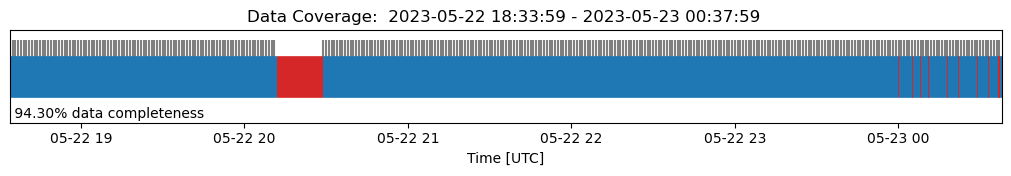

In [197]:
# plot data coverage and gaps
fig, ax = plt.subplots(figsize=(6.4*2,4.8/4.))

# file start
plt.vlines(t_filenames, -0.0, 0.04, color='C7', zorder=0, label='file start')

# time sample spaning for each file
plt.hlines(np.full(len(t_span_files),0), 
           [t[0] for t in t_span_files], 
           [t[1] for t in t_span_files], linewidth=30, color='C0', label='data')
# data gaps within the each file
plt.hlines(np.full(len(t_gaps),0), 
           [t[0] for t in t_gaps], 
           [t[1] for t in t_gaps], linewidth=30, color='C3')#, label='no data')
# data gaps between two files
plt.hlines(np.full(len(t_file_gaps),0), 
           [t[0] for t in t_file_gaps], 
           [t[1] for t in t_file_gaps], linewidth=30, color='C3')
# data gaps at start of files
plt.hlines(np.full(len(t_start_gaps),0), 
           [t[0] for t in t_start_gaps], 
           [t[1] for t in t_start_gaps], linewidth=30, color='C3')

ax.set_yticks([])
ax.set_xlim(t_span_files[0][0],t_span_files[-1][1])
ax.set_ylim(-0.05,0.05)
ax.set_xlabel('Time [UTC]')
plt.text(t_span_files[0][0],-0.045,' {:.2f}% data completeness'.format(100*(1-gaps_share)))
plt.title('Data Coverage:  {} - {} '.format(t_span_files[0][0].strftime('%Y-%m-%d %H:%M:%S'), 
                                            t_span_files[-1][1].strftime('%Y-%m-%d %H:%M:%S')))

**Legend:** \
*blue:* data \
*red:* no data \
*grey:* start of file